<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{spacy-v3} -->

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/spacy/SpaCy_v3_and_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with spaCy v3 and W&B

In this notebook, we'll be training a multi-label CNN text classifier using spaCy v3 on Google's GoEmotions dataset. We'll be tracking our models' progress and saving its outputs using Weights and Biases (W&B). 

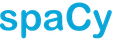

**TextCat GoEmotions Project**

The notebook is based on the [TextCat GoEmotions](https://github.com/explosion/projects/tree/v3/tutorials/textcat_goemotions) spaCy Project. In spaCy's full TextCat GoEmotions project on github you can do also pre-processing, evaluation and even package the project and visualize the outputs!

**SpaCy Projects**

[SpaCy Projects](https://spacy.io/usage/projects) let you manage and share end-to-end spaCy workflows for different use cases and domains, and orchestrate training, packaging and serving your custom pipelines. 


# Setup

In [ ]:
!pip install -qq "spacy >= 3.0.6"
!pip install -qq wandb --upgrade

In [ ]:
import os
from pathlib import Path

# Google's GoEmotions Dataset

Here we'll be doing multilabel text classification on the [GoEmotions dataset](https://github.com/google-research/google-research/tree/master/goemotions), a corpus of 58k curated comments extracted from Reddit, with human annotations of 28 different emotions. Here is an example from the [GoEmotions paper](https://arxiv.org/pdf/2005.00547v2.pdf): 

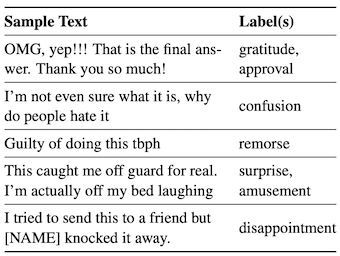

### ✍️ Login to wandb ✍️



In [ ]:
import wandb
wandb.login()

### ✍️ Download from W&B Artifacts ✍️

To keep things focused on the training, we will download a pre-processed version of the GoEmotions dataset using Weights and Biases Artifacts. With Artifacts you get **100GB free storage** to use for your data and model versioning or however you like!

#### Corpora
The train, dev and test corpora are stored in the `.spacy` [binary format](https://spacy.io/api/data-formats#training) that spaCy's training function expects. To see how Googles `.txt` files were converted to `.spacy` files have a look at this [gist file here](https://gist.github.com/morganmcg1/a43842b847e2ff7dc78d2c3e5990bb96)


#### Training Config

[Training in spaCy v3](https://spacy.io/usage/training) revolves around using a configuration file to set up your model and any hyperparameters you might need. In this notebook we will use a modified version of the [`cnn.cfg`](https://github.com/explosion/projects/blob/v3/tutorials/textcat_goemotions/configs/cnn.cfg) from the spaCy project repo

#### Start Download

Lets download the directory which contains our 3 corpora and 1 configuration file

In [ ]:
# W&B Artifact naming convention: `wandb_entity/wandb_project/artifact_name:version`
spacy_artifact = 'wandb/spacy/spacy_demo:v3'

# Our output directory name
spacy_dir = Path("my_spacy_demo") 

By creating a wandb run context we can easily download artifacts 

In [ ]:
with wandb.init(project='spacy_demo') as run: # "config" is optional here
    artifact = run.use_artifact(spacy_artifact)
    _ = artifact.download(spacy_dir)

# Training a Classifier

### spaCy Config

**✍️ WandbLogger ✍️**

The only change made to the configuration file from the original spaCy project was to change the training logger. Instead of using the default console logger, we can use the [spaCy W&B logger](https://spacy.io/api/top-level#WandbLogger) to get a richer display of our training metrics. This can be done by simply adding the following code to our config file:

```
[training.logger]
@loggers = "spacy.WandbLogger.v2"

# Our W&B Project name
project_name = "spacy_demo"  

# Any config data you do not want logged to W&B  
remove_config_values = ["paths.train", "paths.dev", "corpora.train.path", "corpora.dev.path"] 

# Optional, log this dataset folder to W&B Artifacts
log_dataset_dir = "./my_spacy_demo/corpus"  

# Optional, log the model every N steps to W&B Artifacts
model_log_interval = 1200  
```

**Training Params**

In our training we can define our training regime. This example will train until the eval score hasn't improved for 400 steps or until it has trained for 10,000 steps. We can also choose to accumulate gradients if we like, in this case we will not

```
[training]
...
max_epochs = 0
patience = 400
max_steps = 6000
eval_frequency = 200
accumulate_gradient = 1
```

### Model Architecture

Our config also defines with model architecture to use, in this case we are using spaCy's [`TextCatCNN`](https://spacy.io/api/architectures#TextCatCNN) architecture which is:

> a neural network model where token vectors are calculated using a CNN. The vectors are mean pooled and used as features in a feed-forward network. 

Our embedding layer is defined [`MultiHashEmbed`](https://spacy.io/api/architectures#MultiHashEmbed) which:
>  lets the model take into account some subword information, without construction a fully character-based representation.

You can read more about spaCy model architectures [here](https://spacy.io/usage/layers-architectures#_title)

### Tokenizer

This config uses spaCy's [default tokenizer](https://spacy.io/api/tokenizer#_title)

### 🏋️ Train

Once we have our configuration setup, we can call `spacy train` to begin training our models. If we like we can override the data paths in the config, as well as define what GPU to run the training on in the case that we have multiple GPUs

Once training starts we will be able to track our runs by clicking on the 🚀 run link that is output

In [ ]:
!python -m spacy train my_spacy_demo/configs/cnn.cfg \
 --paths.train my_spacy_demo/corpus/train.spacy \
 --paths.dev my_spacy_demo/corpus/dev.spacy \
 -o my_spacy_demo/training/cnn \
 --gpu-id 0

# Using our Trained Model

We can now quickly use our trained classifier model to retrieve predictions on the emotion of different texts. First we get write texts

In [ ]:
texts = ["This is a fabulous idea, this made be so happy and excited, I want to jump for joy",
        "This movie was terrifying, I jumped out of my seat I was so scared, I never want to watch this again"]

We load our spaCy model from disk

In [ ]:
import spacy
nlp = spacy.load("my_spacy_demo/training/cnn/model-best")

And now we can easily get the model's score for each of the emotions by using spaCys [pipeline method](https://spacy.io/usage/processing-pipelines#pipelines), `nlp.pipe`

In [ ]:
category_scores = [doc.cats for doc in nlp.pipe(texts)]
category_scores[0]

While training our multi-label classifier, we defined our score threshold as 0.5. Using that we can now get the top emotions predicted for our 2 samples texts

In [ ]:
thresh = 0.5
for d in category_scores:
  print(dict((k, v) for k, v in d.items() if v >= thresh))

Not bad!

# ✅ Done 

In this notebook we have downloaded our dataset from, trained a model using spacy v3 and saved our datast and model checkpoints to W&B Artifacts. 

### W&B Integrations

Weights and Biases has been integrated with all of the major machine learning libraries, including Hugging Face, Keras, Pytorch Lightning, Fastai and more. You can see the full list in our [integrations docs here](https://docs.wandb.ai/guides/integrations)

### More to come!
This is just a quick intro to the power of spaCy v3 and how W&B can support your ML workflow - **stay tuned for more**! In the meantime, come check out [Fully Connected](https://wandb.ai/fully-connected), a place for the ML community to share their work, collaborate and learn from each other.